# 04 — Regression (Supervised) for PM2.5 (Tabular Time-Lag Features)
Mục tiêu:
- Biến bài toán chuỗi thời gian thành bài toán **hồi quy có giám sát**: dự đoán PM2.5(t+h) từ đặc trưng tại thời điểm t.
- Thấy rõ: **leakage** và vì sao phải split theo thời gian.
- So sánh tư duy hồi quy (feature-based) vs ARIMA (time-series-based).


In [1]:
from pathlib import Path

# ===== PARAMETERS =====
USE_UCIMLREPO = False

# Path to the raw ZIP (relative to project root)
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

def resolve_project_root(raw_zip_rel: str) -> Path:
    """Resolve project root robustly for both Jupyter and Papermill runs.

    Papermill may execute notebooks with different working directories depending on how you run the pipeline.
    This helper tries:
      1) current working directory
      2) parent directory
      3) up to 3 levels up (useful when running from notebooks/ or notebooks/runs)
    """
    cwd = Path.cwd().resolve()

    # Common candidates
    candidates = [cwd, cwd.parent]

    # Climb up a few levels just in case
    root = cwd
    for _ in range(3):
        candidates.append(root)
        root = root.parent

    for r in candidates:
        if (r / raw_zip_rel).exists():
            return r

    # Fallback: keep cwd; downstream will raise a clear error message if missing
    return cwd

PROJECT_ROOT = resolve_project_root(RAW_ZIP_PATH)
RAW_ZIP_ABS = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())

LAG_HOURS = [1, 3, 24]
HORIZON = 1              # dự đoán trước bao nhiêu giờ
TARGET_COL = 'PM2.5'

OUTPUT_REG_DATASET_PATH = 'data/processed/dataset_for_regression.parquet'
CUTOFF = '2017-01-01'

MODEL_OUT = 'regressor.joblib'
METRICS_OUT = 'regression_metrics.json'
PRED_SAMPLE_OUT = 'regression_predictions_sample.csv'


In [3]:
import json
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, str(PROJECT_ROOT))

from src.classification_library import Paths
from src.regression_library import (
    run_prepare_regression_dataset,
    run_train_regression,
)

paths = Paths(project_root=PROJECT_ROOT)
print('PROJECT_ROOT =', PROJECT_ROOT)
print('RAW_ZIP_ABS =', RAW_ZIP_ABS)


PROJECT_ROOT = C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4
RAW_ZIP_ABS = C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\data\raw\PRSA2017_Data_20130301-20170228.zip


## 1) Tạo dataset hồi quy (lag features + time features + y = PM2.5(t+h))
Trong lab, phần này giúp sinh viên hiểu cách tạo supervised dataset từ time series.

In [4]:
out_path = run_prepare_regression_dataset(
    paths=paths,
    use_ucimlrepo=USE_UCIMLREPO,
    raw_zip_path=RAW_ZIP_ABS,
    lag_hours=LAG_HOURS,
    horizon=HORIZON,
    target_col=TARGET_COL,
)
print('Saved:', out_path)


Saved: C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\data\processed\dataset_for_regression.parquet


## 2) Quick EDA cho dataset hồi quy
Gợi ý câu hỏi ra quyết định:
- Tỉ lệ missing ở các feature lag? (thường thiếu ở đầu chuỗi)
- PM2.5 có phân phối lệch (skew) không? -> cân nhắc log/clip (tuỳ chọn)
- Có khác biệt theo *giờ trong ngày* / *ngày trong tuần* không? (seasonality)


(420768, 57)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24,y
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


CO_lag24     0.049849
CO_lag3      0.049284
CO_lag1      0.049227
CO           0.049198
O3_lag24     0.032203
O3_lag3      0.031640
O3_lag1      0.031583
O3           0.031554
NO2_lag24    0.029446
NO2_lag3     0.028881
NO2_lag1     0.028823
NO2          0.028795
SO2_lag24    0.022091
SO2_lag3     0.021525
SO2_lag1     0.021468
dtype: float64

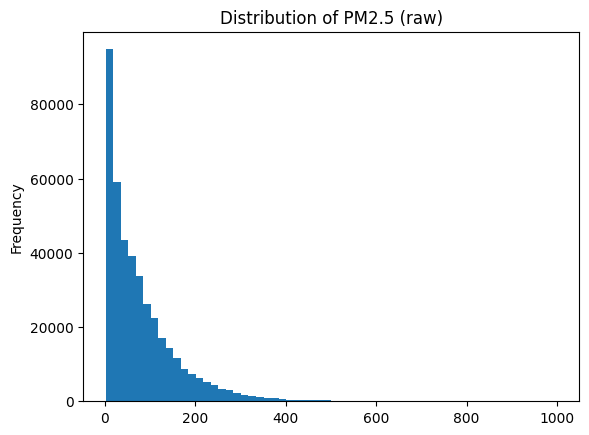

In [5]:
ds_path = (PROJECT_ROOT / OUTPUT_REG_DATASET_PATH).resolve()
df = pd.read_parquet(ds_path)
print(df.shape)
display(df.head())

missing = df.isna().mean().sort_values(ascending=False).head(15)
display(missing)

plt.figure()
pd.Series(df[TARGET_COL]).dropna().plot(kind='hist', bins=60)
plt.title(f'Distribution of {TARGET_COL} (raw)')
plt.show()


## 3) Train/Test theo thời gian + train regressor
Lưu ý: mô hình hồi quy ở đây là **feature-based** (dùng lag + thời tiết).
Phần dự báo chuỗi thời gian *thuần* sẽ làm bằng ARIMA ở notebook kế tiếp.

Metrics:
{
  "n_train": 395301,
  "n_test": 16716,
  "rmse": 25.32672696176382,
  "mae": 12.323158305172308,
  "smape_pct": 23.837711259945234,
  "r2": 0.949150877210564,
  "feature_cols": [
    "No",
    "year",
    "month",
    "day",
    "hour",
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3",
    "TEMP",
    "PRES",
    "DEWP",
    "RAIN",
    "wd",
    "WSPM",
    "station",
    "hour_sin",
    "hour_cos",
    "dow",
    "is_weekend",
    "PM2.5_lag1",
    "PM10_lag1",
    "SO2_lag1",
    "NO2_lag1",
    "CO_lag1",
    "O3_lag1",
    "TEMP_lag1",
    "PRES_lag1",
    "DEWP_lag1",
    "RAIN_lag1",
    "WSPM_lag1",
    "PM2.5_lag3",
    "PM10_lag3",
    "SO2_lag3",
    "NO2_lag3",
    "CO_lag3",
    "O3_lag3",
    "TEMP_lag3",
    "PRES_lag3",
    "DEWP_lag3",
    "RAIN_lag3",
    "WSPM_lag3",
    "PM2.5_lag24",
    "PM10_lag24",
    "SO2_lag24",
    "NO2_lag24",
    "CO_lag24",
    "O3_lag24",
    "TEMP_lag24",
    "PRES_lag24",
    "DEWP_lag24",
    "RAIN_lag24",

,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,477.0,436.901040
1,2017-01-01 01:00:00,Aotizhongxin,454.0,444.198916
2,2017-01-01 02:00:00,Aotizhongxin,418.0,433.323668
3,2017-01-01 03:00:00,Aotizhongxin,438.0,371.884739
4,2017-01-01 04:00:00,Aotizhongxin,453.0,464.841039


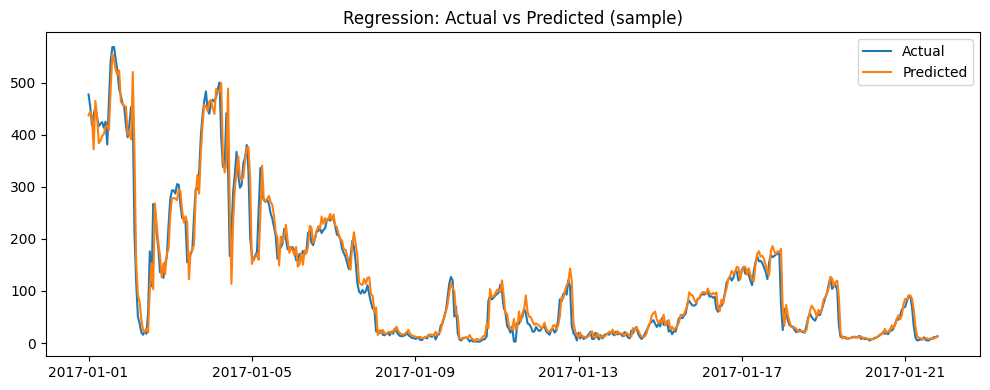

In [6]:
out = run_train_regression(
    paths=paths,
    cutoff=CUTOFF,
    model_out=MODEL_OUT,
    metrics_out=METRICS_OUT,
    preds_out=PRED_SAMPLE_OUT,
)

print('Metrics:')
print(json.dumps(out['metrics'], ensure_ascii=False, indent=2))
pred_df = out['pred_df']
display(pred_df.head())

# Plot a small window for storytelling
sample = pred_df.dropna().iloc[:500].copy()
plt.figure(figsize=(10,4))
plt.plot(sample['datetime'], sample['y_true'], label='Actual')
plt.plot(sample['datetime'], sample['y_pred'], label='Predicted')
plt.title('Regression: Actual vs Predicted (sample)')
plt.legend()
plt.tight_layout()
plt.show()


PHÂN TÍCH RMSE VS MAE
MAE:  12.32
RMSE: 25.33
R²:   0.9492

RMSE/MAE ratio: 2.06

** RMSE >> MAE: Mô hình có một số sai số lớn (spike/outliers)
   => Cần cải thiện khả năng dự báo các đỉnh ô nhiễm cao

** Phân phối Error:
   Mean error: -2.39
   Std error:  25.21
   Max |error|: 480.56
   95th percentile |error|: 44.08


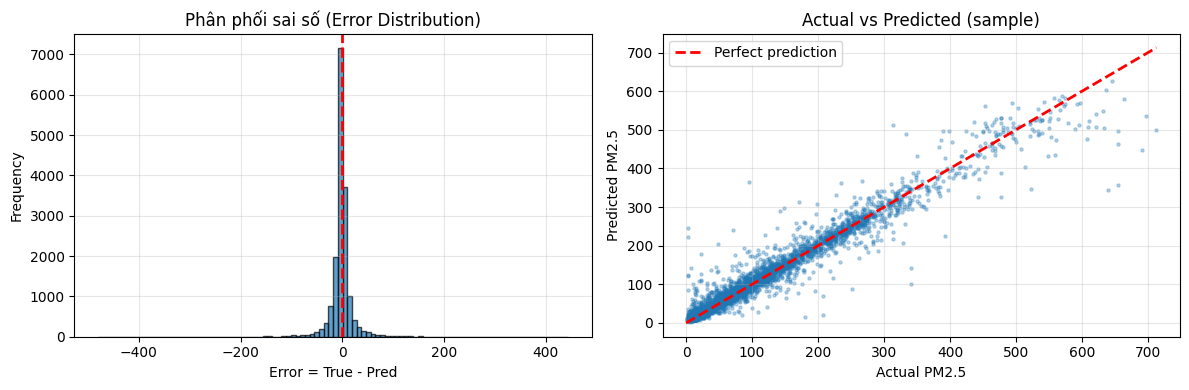


KẾT LUẬN Q2:
1. Lag 24h quan trọng vì PM2.5 có chu kỳ theo ngày (hoạt động, khí tượng)
2. Time-based split tránh leakage, mô phỏng đúng thực tế dự báo
3. RMSE phạt nặng sai số lớn → quan trọng cho cảnh báo đỉnh ô nhiễm
4. MAE phản ánh sai số trung bình → dễ hiểu cho người dùng


In [8]:
# Phân tích chi tiết RMSE vs MAE
print("="*60)
print("PHÂN TÍCH RMSE VS MAE")
print("="*60)

# Lấy metrics từ kết quả train
mae = out['metrics']['mae']
rmse = out['metrics']['rmse']
r2 = out['metrics']['r2']

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"\nRMSE/MAE ratio: {rmse/mae:.2f}")

if rmse/mae > 1.5:
    print("\n** RMSE >> MAE: Mô hình có một số sai số lớn (spike/outliers)")
    print("   => Cần cải thiện khả năng dự báo các đỉnh ô nhiễm cao")
else:
    print("\n** RMSE ≈ MAE: Sai số phân bố tương đối đều")
    print("   => Mô hình ổn định, ít sai số cực đoan")

# Phân tích phân phối error
errors = pred_df['y_true'] - pred_df['y_pred']
errors_clean = errors.dropna()

print(f"\n** Phân phối Error:")
print(f"   Mean error: {errors_clean.mean():.2f}")
print(f"   Std error:  {errors_clean.std():.2f}")
print(f"   Max |error|: {errors_clean.abs().max():.2f}")
print(f"   95th percentile |error|: {errors_clean.abs().quantile(0.95):.2f}")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of errors
axes[0].hist(errors_clean, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Phân phối sai số (Error Distribution)')
axes[0].set_xlabel('Error = True - Pred')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

# Scatter: actual vs predicted
sample_scatter = pred_df.dropna().sample(min(5000, len(pred_df.dropna())))
axes[1].scatter(sample_scatter['y_true'], sample_scatter['y_pred'], alpha=0.3, s=5)
axes[1].plot([0, sample_scatter['y_true'].max()], [0, sample_scatter['y_true'].max()], 
             'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('Actual PM2.5')
axes[1].set_ylabel('Predicted PM2.5')
axes[1].set_title('Actual vs Predicted (sample)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KẾT LUẬN Q2:")
print("="*60)
print("1. Lag 24h quan trọng vì PM2.5 có chu kỳ theo ngày (hoạt động, khí tượng)")
print("2. Time-based split tránh leakage, mô phỏng đúng thực tế dự báo")
print("3. RMSE phạt nặng sai số lớn → quan trọng cho cảnh báo đỉnh ô nhiễm")
print("4. MAE phản ánh sai số trung bình → dễ hiểu cho người dùng")
print("="*60)

## Q2: Giải thích Baseline Hồi Quy cho Dự Báo

Theo yêu cầu Q2, sinh viên cần hiểu và giải thích được 3 điểm chính:

### 1. Vì sao lag 24h thường có ý nghĩa?
- **Chu kỳ hoạt động theo ngày**: Con người có nhịp sinh hoạt lặp lại mỗi ngày (giờ cao điểm, giờ nghỉ ngơi)
- **Điều kiện khí tượng**: Nhiệt độ, áp suất, gió thường có pattern theo ngày
- **Ô nhiễm nguồn**: Giao thông, công nghiệp hoạt động theo chu kỳ ngày
- **Kết quả**: PM2.5 hôm nay có xu hướng tương tự PM2.5 cùng giờ hôm qua

### 2. Vì sao phải chia theo thời gian bằng cutoff?
- **Tránh data leakage**: Nếu trộn tương lai vào quá khứ (random split), mô hình "nhìn thấy tương lai"
- **Mô phỏng thực tế**: Trong thực tế, ta chỉ có dữ liệu quá khứ để dự đoán tương lai
- **Đánh giá đúng**: Time-based split đảm bảo đánh giá trên dữ liệu mà mô hình chưa từng thấy
- **Ví dụ cutoff='2017-01-01'**: Train trên 2013-2016, test trên 2017

### 3. Phân biệt RMSE và MAE
- **MAE (Mean Absolute Error)**:
  - Công thức: `mean(|y_true - y_pred|)`
  - Ý nghĩa: Trung bình sai số tuyệt đối
  - Ưu điểm: Dễ hiểu, ít nhạy với outliers
  - Phù hợp: Khi muốn biết "trung bình mỗi lần dự báo lệch bao nhiêu đơn vị"

- **RMSE (Root Mean Squared Error)**:
  - Công thức: `sqrt(mean((y_true - y_pred)^2))`
  - Ý nghĩa: Căn bậc hai của sai số bình phương trung bình
  - Ưu điểm: Phạt mạnh các sai số lớn (vì bình phương)
  - Phù hợp: Khi muốn tránh dự báo lệch quá nhiều (đặc biệt với spike PM2.5)

- **Khi nào RMSE >> MAE?**
  - Khi dữ liệu có spike hoặc outliers
  - Khi dự báo sai mạnh ở một số thời điểm
  - Với PM2.5 có đuôi phải dài, RMSE thường cao hơn MAE đáng kể